In [1]:
from __future__ import division
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import json
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
import string
import math
from dota_function_definitions import create_dota_dataframe2

In [2]:
with open('automatchdetails_feb26_to_feb29.txt', 'r') as text:
    dotaString = text.read()

In [3]:
with open('heroes.txt', mode='r') as infile:
    reader = csv.reader(infile)
    heroDict = {rows[0]:rows[1] for rows in reader}

In [4]:
dotaString = string.replace(dotaString, '][', ', ')
matchDetailsJSON = json.loads(dotaString)

In [5]:
dotaFrame = create_dota_dataframe2(matchDetailsJSON)

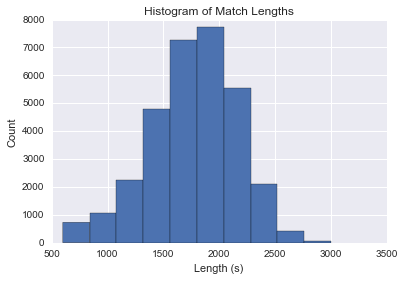

In [7]:
%matplotlib inline
ax = dotaFrame['Match Length (s)'].hist()
ax.set(xlabel='Length (s)', ylabel='Count', title='Histogram of Match Lengths')

We've now imported a fairly large number of matches into a pandas dataframe. From the above plot, the most played game modes are 1 (All Pick) and 22 (Ranked All Pick) which are the only two game modes where all ten players have complete freedom of choice in picking their hero. These two modes embody the chaos that is the 'draft' portion of public matchmaking Dota 2 game, so we will only look at matches for these two game modes in our model. We will also cut out any matches ending before 10 minutes as games that end that early tend to have some skewed factor such as a player abandoning the game early.

In [8]:
dotaFrame = pd.concat([dotaFrame[dotaFrame['Game Mode']==1], dotaFrame[dotaFrame['Game Mode']==22]])
dotaFrame = dotaFrame[dotaFrame['Match Length (s)']>599]

There are 111 heroes currently in the game using hero IDs 1 to 113 (IDs 24 and 108 are unused for reasons unknown). To perform logistic regression, we will use 113 on/off switches for each team indicating whether or not that particular hero is present on the team in a game. Since the current dataframe records the hero for each particular player slot as opposed for just a particular team, we will combine the player slots for each team into a single dataframe cell. From there, we can use the get_dummies() function obtain our 226 switches.

In [9]:
dotaFrame['Radiant']='R'+dotaFrame['Radiant 1'].map(str)+','+'R'+dotaFrame['Radiant 2'].map(str)+','+'R'+dotaFrame['Radiant 3'].map(str)+','+'R'+dotaFrame['Radiant 4'].map(str)+','+'R'+dotaFrame['Radiant 5'].map(str)
dotaFrame['Dire']='D'+dotaFrame['Dire 1'].map(str)+','+'D'+dotaFrame['Dire 2'].map(str)+','+'D'+dotaFrame['Dire 3'].map(str)+','+'D'+dotaFrame['Dire 4'].map(str)+','+'D'+dotaFrame['Dire 5'].map(str)

In [10]:
dotaFrameLogitRadiant = dotaFrame['Radiant'].str.get_dummies(sep=',')
dotaFrameLogitDire = dotaFrame['Dire'].str.get_dummies(sep=',')

In [11]:
dotaFrameLogit = dotaFrameLogitRadiant.join(dotaFrameLogitDire)
dotaFrameLogit['Intercept']=1
dotaFrameLogit['Radiant Win Y/N'] = dotaFrame['Radiant Win Y/N']

We add an intercept term and the winning team information to the resultant dataframe. As seen below, all the data is now represented as 0s and 1s.

In [12]:
dotaFrameLogit.head(10)

,R1,R10,R100,R101,R102,R103,R104,R105,R106,R107,...,D92,D93,D94,D95,D96,D97,D98,D99,Intercept,Radiant Win Y/N
12,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,True
15,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,True
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,True
21,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,True
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,True
24,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,True
26,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,True
32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
34,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False


We'll split the data into a training set and a testing set. The model will be fit to the training set, and then we will test the model's efficacy on the testing set.

In [13]:
dotaFrameTrain, dotaFrameTest = train_test_split(dotaFrameLogit, test_size=0.25, random_state=0)

In [14]:
len(dotaFrameTrain)

23994

In [15]:
len(dotaFrameTest)

7998

In [16]:
trainColumn = list(dotaFrameLogit.columns.values)[0:-1]

In [17]:
model = sm.Logit(dotaFrameTrain['Radiant Win Y/N'], dotaFrameTrain[trainColumn])

In [18]:
result = model.fit(method='bfgs', maxiter=200)

Optimization terminated successfully.
         Current function value: 0.613947
         Iterations: 112
         Function evaluations: 113
         Gradient evaluations: 113


In [19]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:        Radiant Win Y/N   No. Observations:                23994
Model:                          Logit   Df Residuals:                    23773
Method:                           MLE   Df Model:                          220
Date:                Thu, 03 Mar 2016   Pseudo R-squ.:                  0.1007
Time:                        21:39:57   Log-Likelihood:                -14731.
converged:                       True   LL-Null:                       -16381.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
R1            -0.5932    3.3e+05   -1.8e-06      1.000     -6.47e+05  6.47e+05
R10           -0.3947    3.3e+05   -1.2e-06      1.000     -6.47e+05  6.47e+05
R100          -0.0229    3.3e+05  -6.93e-08      1.0

In [20]:
trainingPrediction = result.pred_table()

We can plot the confusion matrix to visualize how well the model does against the training set. Tested against the data used to form the model itself, it predicts ~57.2% of the matches successfully. Interestingly, the model seems to misinterpret Radiant Wins as Dire Wins more often than Dire Wins as Radiant Wins.

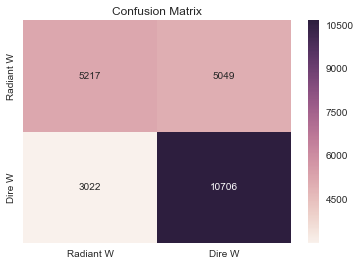

In [21]:
ax = sns.heatmap(trainingPrediction, annot = True, fmt = ".6g", xticklabels = ['Radiant W', 'Dire W'], yticklabels = ['Radiant W', 'Dire W'])
ax.set_title("Confusion Matrix")

In [22]:
dotaFrameTrain['Radiant Win Y/N'].mean()    #percent of matches where Radiant won

0.57214303575893977

In [23]:
ypred = result.predict(dotaFrameTest[trainColumn])

In [24]:
ypred

array([ 0.27061621,  0.87583798,  0.49512483, ...,  0.85708059,
        0.78059465,  0.17454388])

In [25]:
ypred = ypred.round().astype(int)    #convert probabilities to predicted win or loss for Radiant team

In [26]:
ytest = np.ravel(dotaFrameTest['Radiant Win Y/N']).astype(int)  #convert binary dataframe series to int numpy array for comparison

In [27]:
ypred

array([0, 1, 0, ..., 1, 1, 0])

In [28]:
ytest

array([0, 1, 1, ..., 0, 1, 0])

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
accuracy_score(ypred, ytest)

0.66091522880720177

Using this logistic regression model, there is a 66.09% correct prediction rate on the test set.